In [4]:
#Mount Drive if running in Colab
from sys import path
import os

if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  root_PATH = '/content/drive/My Drive/nlp-seminar/repository'
  drive_mount_location = '/content/drive'

  drive.mount(drive_mount_location, force_remount=True)
  path.append(root_PATH)
else:
  root_PATH = os.path.abspath("../..")

%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
from data_cleaner import DataCleaner
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [6]:
#Load datasets
train_df = pd.read_csv(root_PATH + '/data/train.csv')
validation_df = pd.read_csv(root_PATH + '/data/validation.csv')

In [7]:
#Clean datasets for naive Bayes method
train_df['Conversation'] = train_df['Conversation'].map(lambda row : DataCleaner.clean_text_naive_bayes(str(row)))
validation_df['Conversation'] = validation_df['Conversation'].map(lambda row : DataCleaner.clean_text_naive_bayes(str(row)))

In [8]:
#Obtain a list with all the topics in the dataset
train_df["Topic"] = train_df["Topic"].apply(eval)
validation_df["Topic"] = validation_df["Topic"].apply(eval)

def list_to_series(series):
    return pd.Series([x for _list in series for x in _list])

In [9]:
#Add a boolean mask to the dataset
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

train_topics = list_to_series(train_df["Topic"]).value_counts().index.tolist()
train_boolean_mask = boolean_df(train_df["Topic"],train_topics).astype(int)

validation_topics = list_to_series(validation_df["Topic"]).value_counts().index.tolist()
validation_boolean_mask = boolean_df(validation_df["Topic"],train_topics).astype(int)

In [10]:
train_df_complete = train_df.join(train_boolean_mask)
validation_df_complete = validation_df.join(validation_boolean_mask)

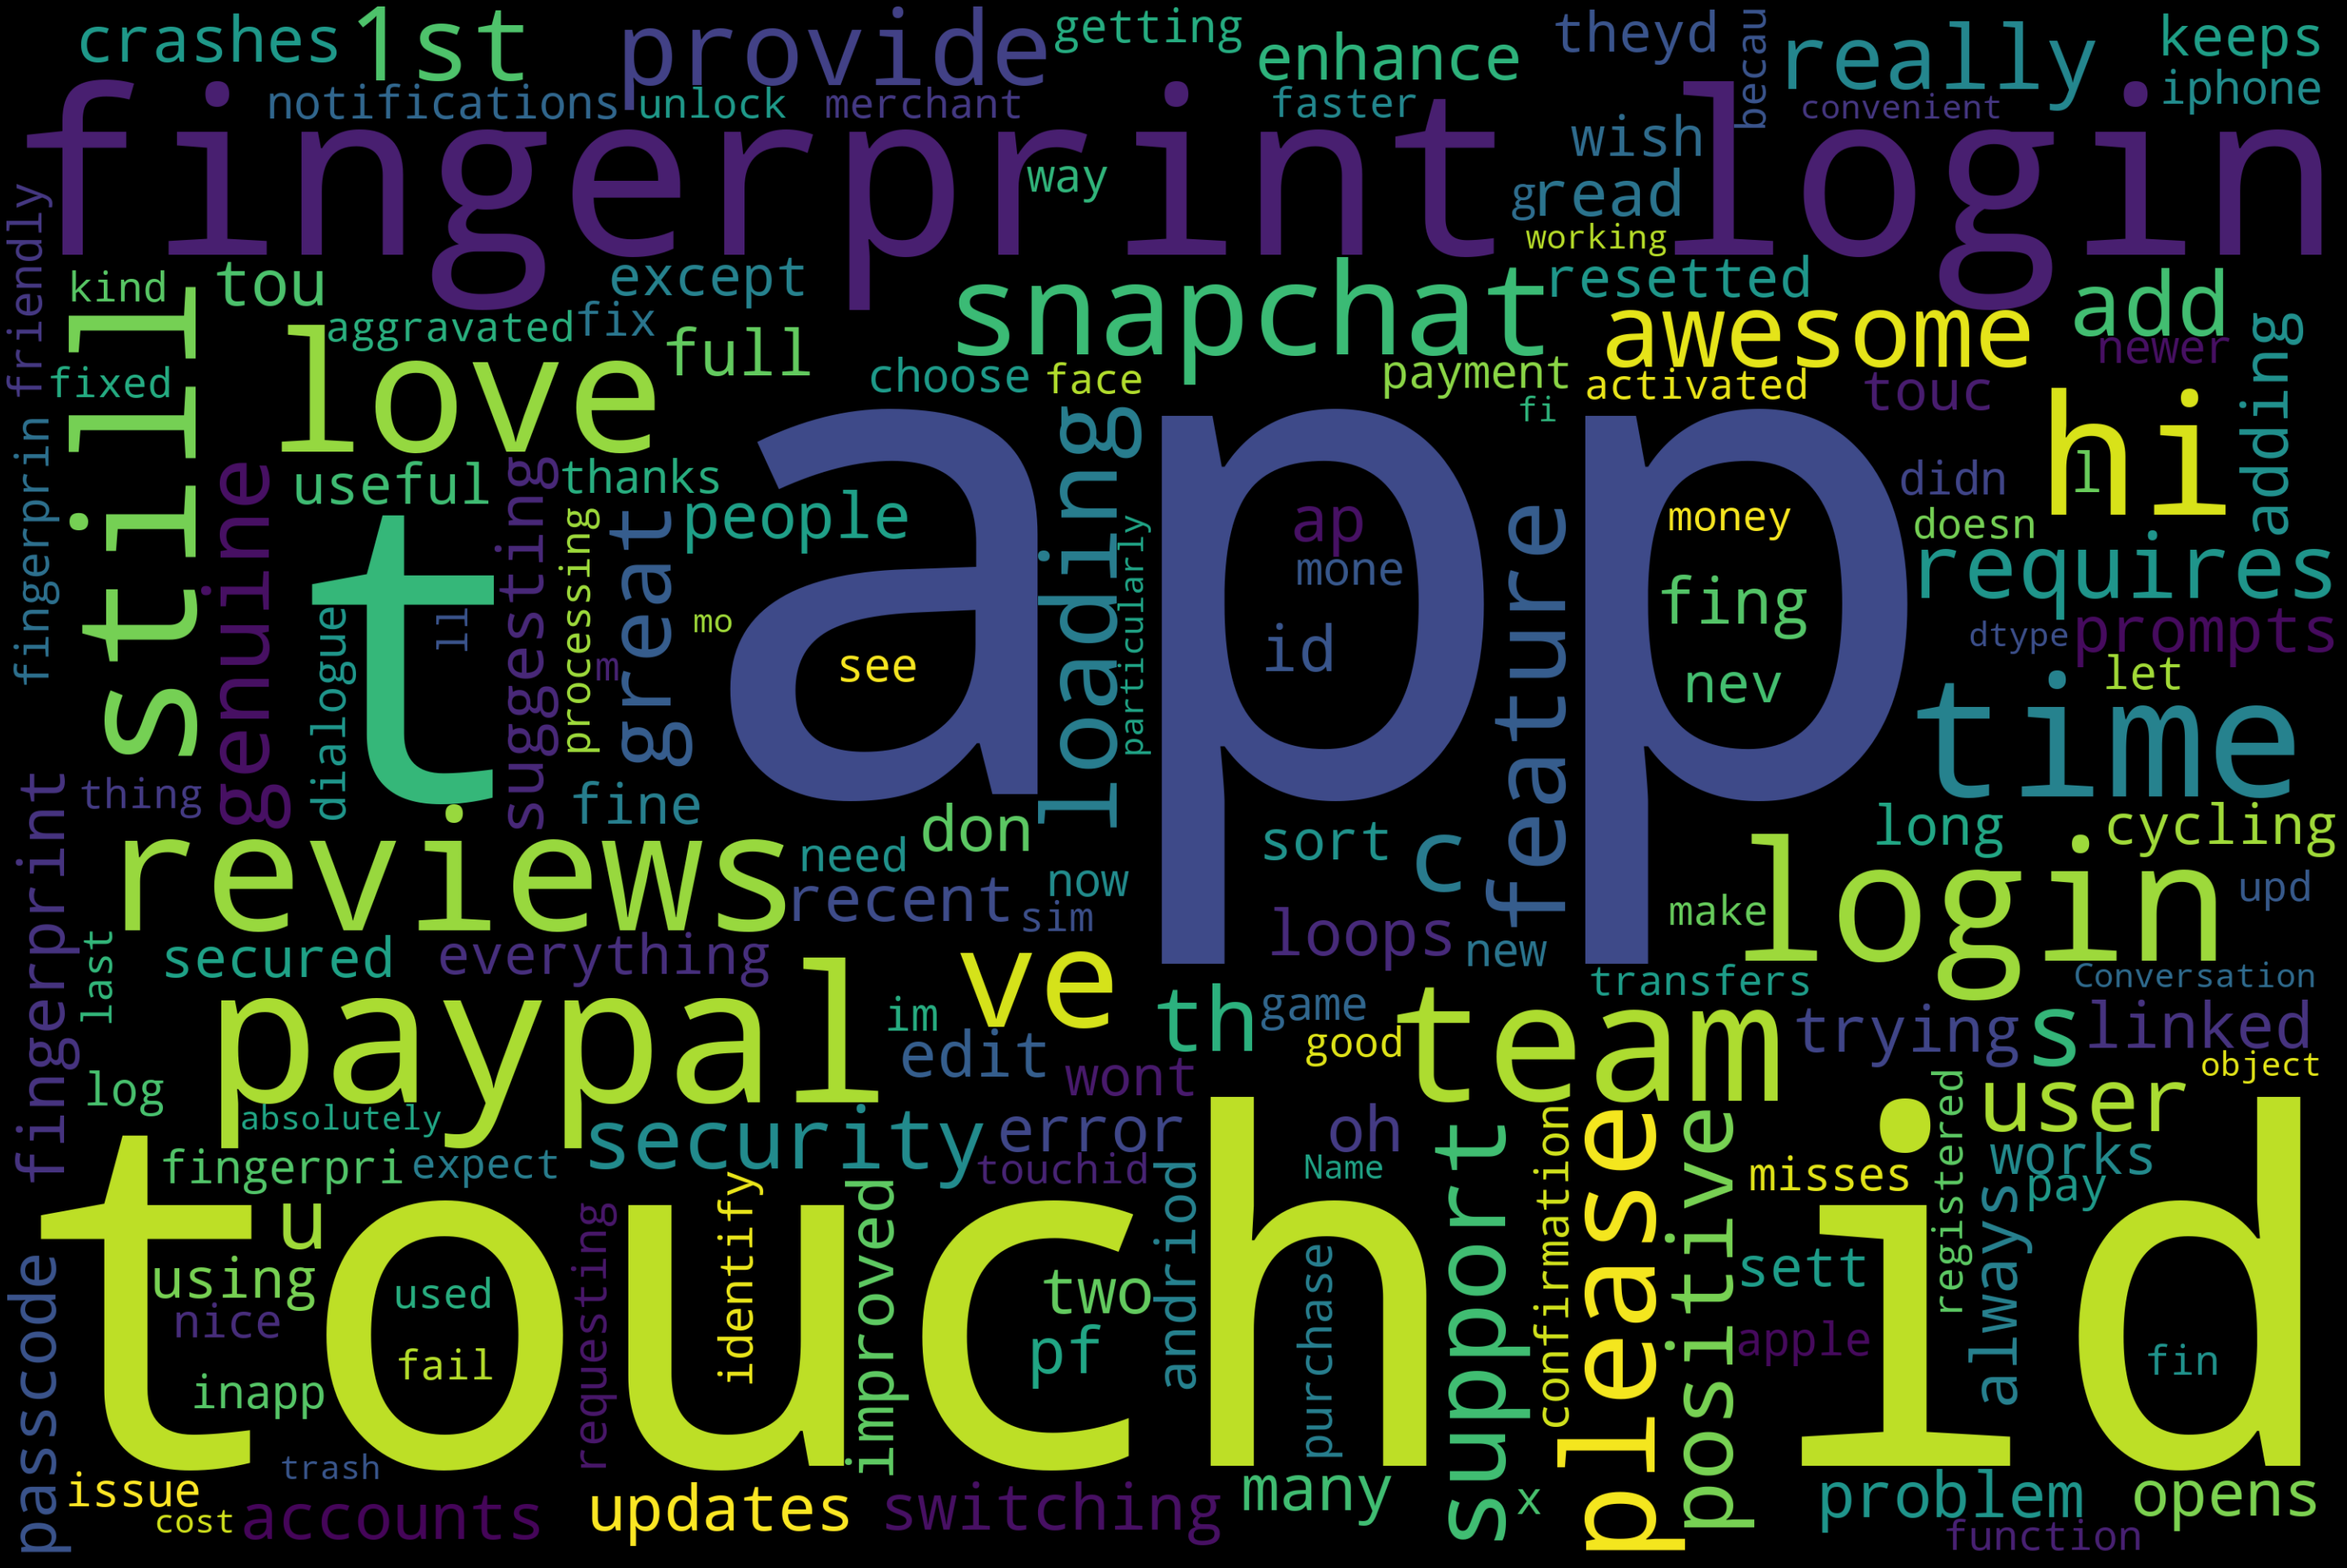

In [11]:
#Wordcloud of the category Touch ID (one of the underrepresented categories, which achieved a great accuracy with a simple Naive Bayes baseline)
topic = "Touch ID"
data_containing_topic = train_df_complete.loc[train_df_complete[topic] == 1]

text = data_containing_topic.Conversation
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [12]:
#All messages related with touch ID have the words "touch id, fingerprint","touchid"?
data_containing_topic

data_with_word = data_containing_topic[data_containing_topic['Conversation'].str.contains("touch id") | data_containing_topic['Conversation'].str.contains("fingerprint") | data_containing_topic['Conversation'].str.contains("touchid")]

data_without_word = data_containing_topic[~data_containing_topic['Conversation'].str.contains("touch id") & ~data_containing_topic['Conversation'].str.contains("fingerprint")]

#Yes, 100% of the messages containing the words "touch id, fingerprint","touchid" have the topic touchid

In [14]:
#TODO:Analyze results for other categories that are not so precise (do they also have key words?).Search for words that appear in most of the sentences. Search for most common bigrams